# Langgraph Quickstart

## Setup

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

assert 'GOOGLE_API_KEY' in os.environ

## Defining an Execution Graph

In [2]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger("langgraph_quickstart")

logger.info("Hello, world!")

2025-07-29 12:25:13,694 - INFO - Hello, world!


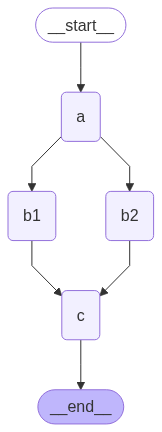

In [3]:
import time 

from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


class State(TypedDict):
    pass

def node_a(state: State) -> State:
    logger.info("Node A")
    return {}

def node_b1(state: State) -> State:
    logger.info("Node B1")
    time.sleep(1)
    return {}

def node_b2(state: State) -> State:
    logger.info("Node B2")
    time.sleep(1)
    return {}

def node_c(state: State) -> State:
    logger.info("Node C")
    return {}

graph = StateGraph(state_schema=State)
graph.add_node("a", node_a)
graph.add_node("b1", node_b1)
graph.add_node("b2", node_b2)
graph.add_node("c", node_c)
graph.add_edge(START, "a")
graph.add_edge("a", "b1")
graph.add_edge("a", "b2")
graph.add_edge("b1", "c")
graph.add_edge("b2", "c")
graph.add_edge("c", END)


compiled_graph = graph.compile()
compiled_graph

In [4]:
compiled_graph.invoke(input={})

2025-07-29 12:25:14,246 - INFO - Node A
2025-07-29 12:25:14,247 - INFO - Node B2
2025-07-29 12:25:14,247 - INFO - Node B1
2025-07-29 12:25:15,256 - INFO - Node C


## Modifying State
Update state with 'Command'


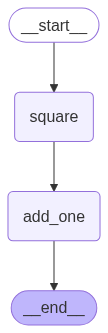

In [5]:
from typing_extensions import TypedDict
from langgraph.types import Command

class State(TypedDict):
    x: int

def square(state: State) -> str:
    return Command(update={"x": state["x"] ** 2})

def add_one(state: State) -> str:
    return Command(update={"x": state["x"] + 1})

graph = StateGraph(state_schema=State)
graph.add_node("square", square)
graph.add_node("add_one", add_one)

graph.add_edge(START, "square")
graph.add_edge("square", "add_one")
graph.add_edge("add_one", END)

compiled_graph = graph.compile()
compiled_graph

In [6]:
compiled_graph.invoke({"x": 2})

{'x': 5}

In [7]:
compiled_graph.invoke({"x": 3})

{'x': 10}

## Adding Memory

In [8]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()

class State(TypedDict):
    pass

def node_a(state: State) -> State:
    namespace=("a",)

    store.put(namespace, "a", 1)
    logger.info("Node A")
    return {}

def node_b(state: State) -> State:
    namespace=("a",)
    store.put(namespace, "a", 1)
    logger.info(f"Node B: {store.get(namespace, "a").value}")
    return {}

graph = StateGraph(state_schema=State)
graph.add_node("a", node_a)
graph.add_node("b", node_b)
graph.add_edge(START, "a")
graph.add_edge("a", "b")
graph.add_edge("b", END)

compiled_graph = graph.compile(store=store)
compiled_graph.invoke(
    input={},
    config={"thread_id": "1"}
)

2025-07-29 12:25:15,470 - INFO - Node A
2025-07-29 12:25:15,471 - INFO - Node B: 1


## Routing

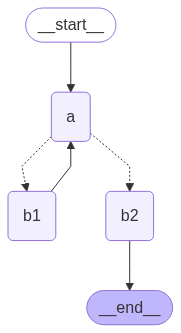

In [9]:

class State(TypedDict):
    flag: bool = False

def node_a(state: State) -> State:
    logger.info("Node A")
    return state

def node_b1(state: State) -> State:
    logger.info("Node B1")
    return {'flag': True}

def node_b2(state: State) -> State:
    logger.info("Node B2")
    return state

def route_node_a(state: State) -> str:
    return "b1" if not state["flag"] else "b2"
    
graph = StateGraph(state_schema=State)
graph.add_node("a", node_a)
graph.add_node("b1", node_b1)
graph.add_node("b2", node_b2)

graph.add_edge(START, "a")
graph.add_conditional_edges("a", route_node_a, {'b1': 'b1', 'b2': 'b2'})
graph.add_edge("b1", "a")
graph.add_edge("b2", END)

compiled_graph = graph.compile()
compiled_graph

In [10]:
compiled_graph.invoke(input={'flag': False})

2025-07-29 12:25:15,613 - INFO - Node A
2025-07-29 12:25:15,616 - INFO - Node B1
2025-07-29 12:25:15,617 - INFO - Node A
2025-07-29 12:25:15,618 - INFO - Node B2


{'flag': True}